## Week 3


**Building models for yourself is great, and can be very powerful. But, as you've seen, you can be limited by the data you have on hand. Not everybody has access to massive datasets or the compute power that's needed to train them effectively. Transfer learning can help solve this -- where people with models trained on large datasets train them, so that you can either use them directly, or, you can use the features that they have learned and apply them to your scenario. This is Transfer learning, and you'll look into that this week!**

---

1. **Transfer learning**

    * Everything about how transfer learning works can be found [here](https://ruder.io/transfer-learning/).

    * You can also see how to do transfer learning in Tensorflow [here](https://www.tensorflow.org/tutorials/images/transfer_learning).

    * The example used this week also addresses this issue, and an implementation is one of the uses of transfer learning.



### example_1

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-06-04 10:13:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.12.240, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   128MB/s    in 0.7s    

2021-06-04 10:13:44 (128 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import RMSprop

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x)

pre_trained_model.summary()

last layer output shape:  (None, 7, 7, 768)
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
___________________________________________

In [ ]:
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-06-04 10:13:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 172.217.13.80, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   184MB/s    in 0.4s    

2021-06-04 10:13:56 (184 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 30,
            validation_steps = 50,
            verbose = 2)

Epoch 1/30
100/100 - 20s - loss: 0.3397 - accuracy: 0.8700 - val_loss: 0.1155 - val_accuracy: 0.9530
Epoch 2/30
100/100 - 16s - loss: 0.2061 - accuracy: 0.9135 - val_loss: 0.1113 - val_accuracy: 0.9640
Epoch 3/30
100/100 - 16s - loss: 0.1986 - accuracy: 0.9250 - val_loss: 0.1542 - val_accuracy: 0.9470
Epoch 4/30
100/100 - 16s - loss: 0.1847 - accuracy: 0.9255 - val_loss: 0.1279 - val_accuracy: 0.9610
Epoch 5/30
100/100 - 16s - loss: 0.1729 - accuracy: 0.9360 - val_loss: 0.1813 - val_accuracy: 0.9380
Epoch 6/30
100/100 - 16s - loss: 0.1740 - accuracy: 0.9320 - val_loss: 0.0951 - val_accuracy: 0.9690
Epoch 7/30
100/100 - 16s - loss: 0.1757 - accuracy: 0.9375 - val_loss: 0.1036 - val_accuracy: 0.9620
Epoch 8/30
100/100 - 16s - loss: 0.1680 - accuracy: 0.9445 - val_loss: 0.1310 - val_accuracy: 0.9570
Epoch 9/30
100/100 - 16s - loss: 0.1595 - accuracy: 0.9420 - val_loss: 0.1001 - val_accuracy: 0.9690
Epoch 10/30
100/100 - 16s - loss: 0.1667 - accuracy: 0.9420 - val_loss: 0.1280 - val_accura

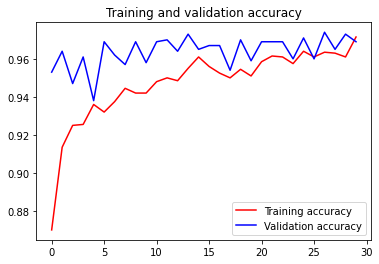

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()